# Redes Residuales

---

En este notebook implementaremos una red neuronal muy profunda utilizando redes residuales.

El framework que usaremos es Keras.

## Preliminares

Empecemos por cargar los paquetes y dependencias que usaremos.

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


## Redes Neuronales Muy Profundas... ¿Tan Poderosas como Parecen?

Aunque es innegable que las redes neuronales profundas están entre los algoritmos de machine learning más poderosos que existen, vienen con un buen número de limitaciones o desventajas que debemos tomar en consideración. 

Una de ellas es el problema del gradiente fantasma, donde la señal del gradiente se aproxima a cero muy rápidamente, haciendo que _gradient descent_ avance increíblemente lento.

Durante el entrenamiento podemos ver que la magnitud del gradiente para las primeras capas disminuye a cero muy rápidamente a medida que el entrenamiento progresa:

<img src="images/vanishing_grad.png" style="width:450px;height:220px;">
<caption><center><u><font color="blue"> Gradiente fantasma <br> La velocidad de aprendizaje disminuye velozmente para las primeras capas de la red mientras entrena.</center> </caption>

## ¡ResNets al Rescate!

Una manera de contrarrestar el problema del gradiente fantasma es mediante las redes residuales o, más brevemente, ResNets.

Un _conexión atajo_ (o _skip connection_) permite que el gradiente sea transmitido directamente hacia las primeras capas de las redes mediante _backpropagation_:

<img src="images/skip_connection.png" style="width:650px;height:200px;">
<caption><center><u><font color="blue">Bloque ResNet con una conexión atajo.</center><caption>
    
La imagen a la izquierda muestra el camino "principal" o tradicional, mientras que la de la derecha nos muestra la conexión entre dos capas no adyacentes.

Al apilar estos bloques podemos construir redes neuronales muy, muy profundas sin pérdida de desempeño.

Hay dos tipos principales de bloques utilizados en una ResNet, dependiento principalmente de las dimensiones de los volúmenes de entrada y salida. Implementémoslos.

## El Bloque Identidad 

Este es el bloque estándar usado en las ResNets. Se utiliza cuando las activaciones de entrada a una capa, digamos, A, tienen las mismas dimensiones que las activaciones de salida de otra capa, B.

<img src="images/idblock2.png" style="width:650px;height:150px;">
<caption><center><u><font color="blue">Bloque identidad con una conexión atajo sobre dos capas.</center></caption>

En esta imagen el camino superior es el atajo, mientras que el inferior es el camino principal. Implementaremos un bloque identidad que salta tres capas en vez de dos, así:
    
<img src="images/idblock3.png" style="width:650px;height:150px;">
<caption><center><u><font color="blue">Bloque identidad con una conexión atajo sobre tres capas.</center></caption>

In [2]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    
    # Retrieve filters
    filter_1, filter_2, filter_3 = filters
    
    X_shortcut = X
    
    # First component of the main path.
    X = Conv2D(
        filters=filter_1,
        kernel_size=(1, 1),
        strides=(1, 1),
        padding='valid', 
        name=f'{conv_name_base}2a',
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}2a')(X)
    X = Activation('relu')(X)
    
    # Second component of the main path
    X = Conv2D(
        filters=filter_2, 
        kernel_size=(f, f), 
        strides=(1, 1), 
        padding='same', 
        name=f'{conv_name_base}2b', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}2b')(X)
    X = Activation('relu')(X)
    
    # Third component of the main path
    X = Conv2D(
        filters=filter_3, 
        kernel_size=(1, 1), 
        strides=(1, 1),
        padding='valid', 
        name=f'{conv_name_base}2c',
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}2c')(X)
    
    # Final step: Add shorcut value to main path and activate with ReLU.
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

Probemos esta función:

In [3]:
tf.reset_default_graph()

with tf.Session() as s:
    np.random.seed(1)
    previous_activations = tf.placeholder('float', [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    activations = identity_block(previous_activations, f=2, filters=[2, 4, 6], stage=1, block='a')
    
    s.run(tf.global_variables_initializer())
    
    out = s.run([activations], feed_dict={previous_activations: X, K.learning_phase(): 0})
    print(f'out: {out[0][1][1][0]}')

out: [0.19716819 0.         1.3561226  2.1713073  0.         1.3324987 ]


## El Bloque Convolucional

El otro tipo de bloque en el reino de las ResNets es el convolucional, el cual se utiliza cuando las dimensiones de las activaciones de entrada, A, difieren con las dimensiones de las activaciones de salida de otra capa, B.

<img src="images/convblock.png" style="width:650px;height:150px;">
<caption><center><u><font color="blue">Bloque convolucional con una conexión atajo sobre dos capas.</center></caption>

La principal diferencia con el bloque identidad es que tenemos una capa convolucional en el atajo, la cual cumple el propósito de hacer que las dimensiones de A y B coincidan.

In [4]:
def convolutional_block(X, f, filters, stage, block, s=2):
    # Defining name basis
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'
    
    # Retrieve filters
    filter_1, filter_2, filter_3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(
        filters=filter_1,
        kernel_size=(1, 1),
        strides=(s, s),
        padding='valid',
        name=f'{conv_name_base}2a',
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(
        filters=filter_2,
        kernel_size=(f, f), 
        strides=(1, 1), 
        name=f'{conv_name_base}2b',
        padding='same', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(
        filters=filter_3,
        kernel_size=(1, 1), 
        strides=(1, 1), 
        name=f'{conv_name_base}2c', 
        padding='valid', 
        kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=f'{bn_name_base}2c')(X)
    
    # Shortcut path
    X_shortcut = Conv2D(
        filters=filter_3,
        kernel_size=(1, 1), 
        strides=(s, s), 
        name=f'{conv_name_base}I', 
        padding='valid', 
        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=f'{bn_name_base}I')(X_shortcut)
    
    # Add both main and shortcut path and pass them through a ReLU activation.
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

Probemos:

In [5]:
tf.reset_default_graph()

with tf.Session() as s:
    np.random.seed(1)
    previous_activations = tf.placeholder('float', [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    activations = convolutional_block(previous_activations, f=2, filters=[2, 4, 6], stage=1, block='a')
    
    s.run(tf.global_variables_initializer())
    
    out = s.run([activations], feed_dict={previous_activations: X, K.learning_phase(): 0})
    print(f'out: {out[0][1][1][0]}')

out: [0.09018463 1.2348979  0.46822023 0.03671762 0.         0.65516603]


## Construyendo una ResNet

Construyamos una ResNet con 50 capas.

Tenemos lo que necesitamos para llevar a cabo esta tarea. La imagen a continuación describe la arquitectura de nuestro modelo.

<img src="images/resnet.png" style="width:850px;height:150px;">
<caption><center><u><font color="blue">ResNet-50.</center></caption>

Estos son los detalles del modelo:

- Zero-padding rellena la entrada con un _pad_ de (3, 3).
- Etapa 1:
    - La Convolution 2D tiene 64 filtros de dimensiones (7, 7) y usa un stride de (2, 2).
    - BatchNorm es aplicado al eje de los canales de la imagen de entrada.
    - MaxPooling usa una ventana de (3, 3) y un stride de (2, 2).
- Etapa 2:
    - El bloque convolucional usa un tres conjuntos de filtros de tamaño (64, 64, 256), "f" es 3, "s" es 1.
    - Los 2 bloques identidad usan un tres conjuntos de filtros de tamaño (64, 64, 256), "f" es 3.
- Etapa 3:
    - El bloque convolucional usa un tres conjuntos de filtros de tamaño (128, 128, 512), "f" es 3, "s" es 1.
    - Los 3 bloques identidad usan un tres conjuntos de filtros de tamaño (128, 128, 512), "f" es 3 y "s" es 2.
- Etapa 4:
    - El bloque convolucional usa un tres conjuntos de filtros de tamaño (256, 256, 1024), "f" es 3, "s" es 1.
    - Los 5 bloques identidad usan un tres conjuntos de filtros de tamaño (256, 256, 1024), "f" es 3 y "s" es 2.
- Etapa 5:
    - El bloque convolucional usa un tres conjuntos de filtros de tamaño (512, 512, 2048), "f" es 3, "s" es 1.
    - Los 5 bloques identidad usan un tres conjuntos de filtros de tamaño (512, 512, 2048), "f" es 3 y "s" es 2.
- La capa Average Pooling 2D usa una ventana de dimensiones de (2, 2).
- La capa de aplanamiento no tiene ningún hiperparámetro. 
- La capa Fully Connected reduce la entrada al número de clases utilizando una activación "softmax".

In [6]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage I
    X = Conv2D(64, 
               (7, 7), 
               strides=(2, 2),
               name='conv1', 
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage II
    X = convolutional_block(X, f=3, filters=(64, 64, 256), stage=2, block='a', s=1)
    X = identity_block(X, 3, (64, 64, 256), stage=2, block='b')
    X = identity_block(X, 3, (64, 64, 256), stage=2, block='c')
    
    # Stage III
    X = convolutional_block(X, f=3, filters=(128, 128, 512), stage=3, s=2, block='a')
    X = identity_block(X, f=3, filters=(128, 128, 512), stage=3, block='b')
    X = identity_block(X, f=3, filters=(128, 128, 512), stage=3, block='c')
    X = identity_block(X, f=3, filters=(128, 128, 512), stage=3, block='d')
    
    # Stage IV
    X = convolutional_block(X, f=3, filters=(256, 256, 1024), stage=4, s=2, block='a')
    X = identity_block(X, f=3, filters=(256, 256, 1024), stage=4, block='b')
    X = identity_block(X, f=3, filters=(256, 256, 1024), stage=4, block='c')
    X = identity_block(X, f=3, filters=(256, 256, 1024), stage=4, block='d')
    X = identity_block(X, f=3, filters=(256, 256, 1024), stage=4, block='e')
    X = identity_block(X, f=3, filters=(256, 256, 1024), stage=4, block='f')
    
    # Stage V
    X = convolutional_block(X, f=3, filters=(512, 512, 2048), stage=5, block='a')
    X = identity_block(X, f=3, filters=(512, 512, 2048), stage=5, block='b')
    X = identity_block(X, f=3, filters=(512, 512, 2048), stage=5, block='c')
    
    # Average pooling
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name=f'fc{classes}', kernel_initializer=glorot_uniform(seed=0))(X)
    
    return Model(inputs=X_input, outputs=X, name='ResNet50')

Construyamos el modelo y compilémoslo.

In [7]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Usemos de nuevo el conjunto de datos SIGN.

<img src="images/signs_data.png">

In [9]:
X_train, y_train, X_test, y_test, classes = load_dataset()

# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# One hot encode
y_train = one_hot_encode(y_train, 6).T
y_test = one_hot_encode(y_test, 6).T

print(f'Number of training examples: {len(X_train)}')
print(f'Number of test examples: {len(X_test)}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

Number of training examples: 1080
Number of test examples: 120
X_train shape: (1080, 64, 64, 3)
y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
y_test shape: (120, 6)


Ahora podemos entrenar el modelo. Debería tomar un buen rato en una CPU normal, y sólo unos cuantos segundos en una GPU.

In [10]:
EPOCHS = 25
BATCH_SIZE = 32

model_history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/25
1080/1080 [==============================] - 112s 103ms/step - loss: 3.0681 - acc: 0.2546
Epoch 2/25
1080/1080 [==============================] - 101s 94ms/step - loss: 2.2668 - acc: 0.3324
Epoch 3/25
1080/1080 [==============================] - 97s 90ms/step - loss: 2.2022 - acc: 0.3722
Epoch 4/25
1080/1080 [==============================] - 93s 86ms/step - loss: 1.7668 - acc: 0.4833
Epoch 5/25
1080/1080 [==============================] - 82s 76ms/step - loss: 1.4237 - acc: 0.5500
Epoch 6/25
1080/1080 [==============================] - 82s 76ms/step - loss: 1.3090 - acc: 0.6370
Epoch 7/25
1080/1080 [==============================] - 82s 76ms/step - loss: 1.0254 - acc: 0.7046
Epoch 8/25
1080/1080 [==============================] - 87s 80ms/step - loss: 0.9123 - acc: 0.7602
Epoch 9/25
1080/1080 [==============================] - 82s 76ms/step - loss: 0.7762 - acc: 0.8231
Epoch 10/25
1080/1080 [==============================] - 83s 76ms/step - loss: 1.0844 - acc: 0.7500
Epoch 

In [11]:
predictions = model.evaluate(X_test, y_test)
print(f'Loss: {predictions[0]}')
print(f'Test accuracy: {predictions[1]}')

120/120 [==============================] - 3s 27ms/step
Loss: 0.379818324247996
Test accuracy: 0.8583333373069764


Parece que le está yendo bien en el conjunto de prueba. 

Hagamos predicciones sobre una imagen nueva.

Input image shape: (1, 64, 64, 3)


/Users/jesusmartinez/miniconda3/envs/resnet/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)]: [[1. 0. 0. 0. 0. 0.]]


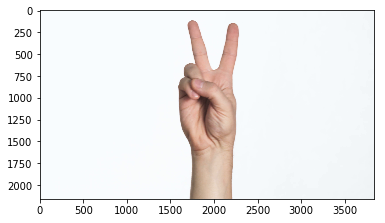

In [13]:
img_path = 'images/my_image.png'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(f'Input image shape: {x.shape}')
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print(f'Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)]: {model.predict(x)}')

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Puedes consultar el paper original sobre ResNets [aquí](https://arxiv.org/abs/1512.03385).